<a href="https://colab.research.google.com/github/dlcodnjs2/2023/blob/main/kNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd

targetUrl = "https://raw.githubusercontent.com/dlcodnjs2/2023/main/fake_bills.csv"

df = pd.read_csv(targetUrl, sep=';')

df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [105]:
# 정답을 one-hot encoding하기
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

ohe.fit(df[['is_genuine']])
AA = ohe.transform(df[['is_genuine']])

AA = pd.DataFrame(AA)
AA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1500 non-null   float64
 1   1       1500 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


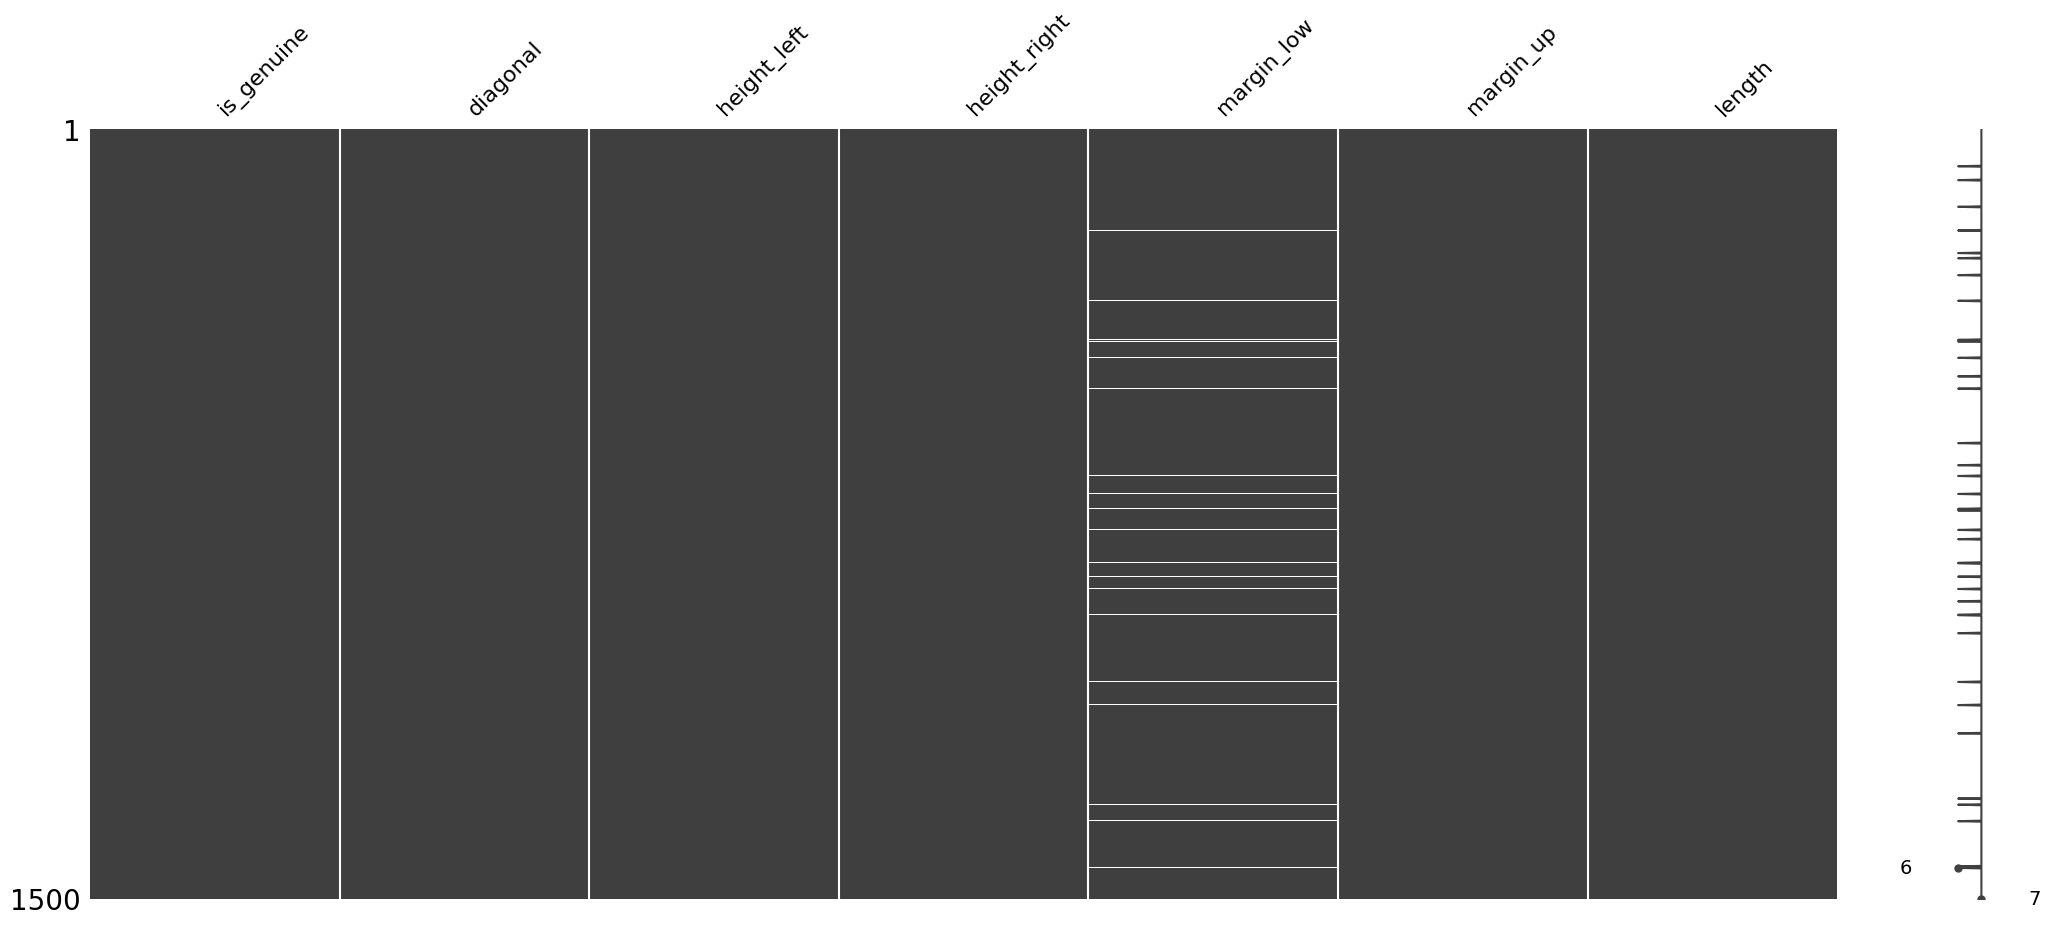

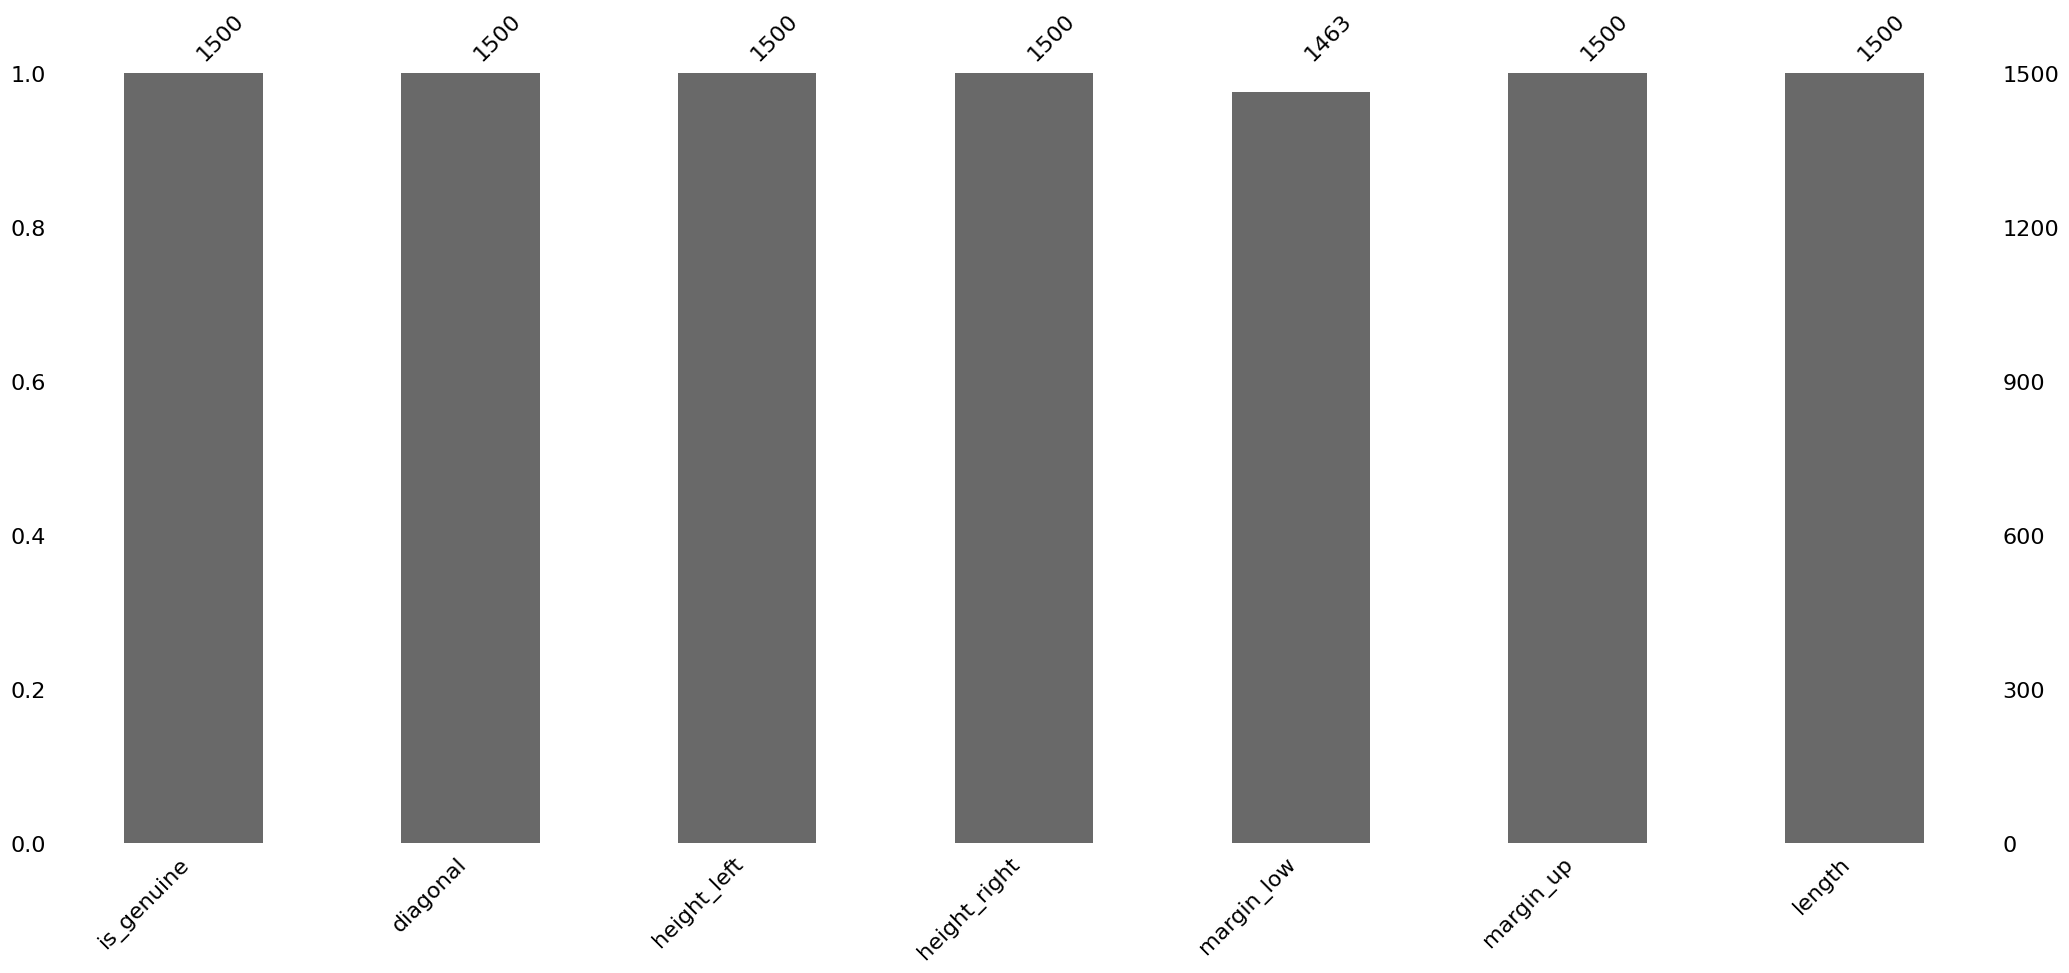

In [106]:
# 결측치 확인
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()

msno.bar(df)
plt.show()

In [107]:
# kNN으로 결측치 채우기
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

df_imputed = imputer.fit_transform(df)

df_imputed2 = pd.DataFrame(df_imputed)

df_imputed2.columns = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

df_imputed2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   float64
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(7)
memory usage: 82.2 KB


In [108]:
# train dataset과 test dataset을 구분(stratify 옵션 사용)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_imputed2.iloc[:,1:7],df_imputed2.loc[:,'is_genuine'], test_size=0.2, stratify=df_imputed2.loc[:,'is_genuine'], random_state=0)

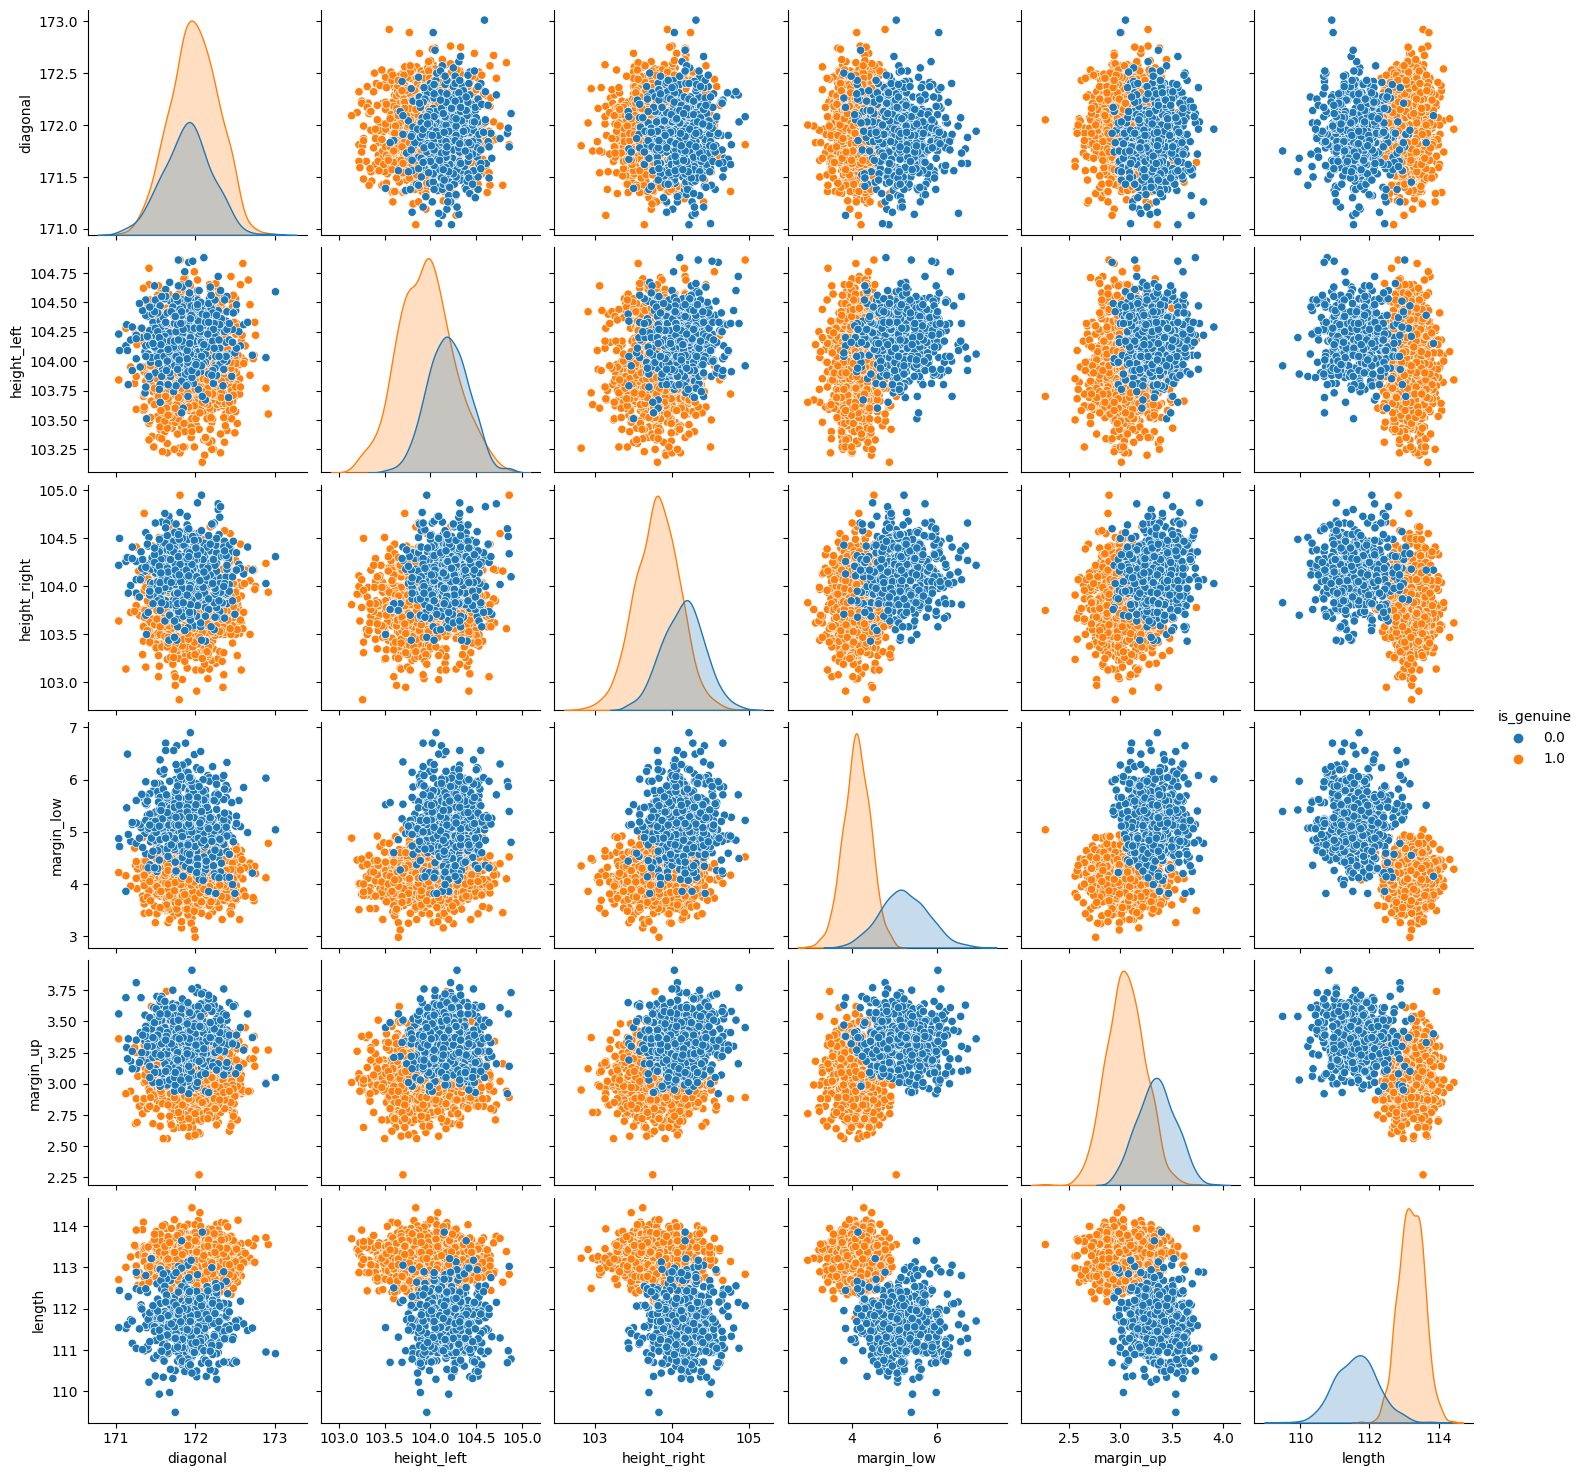

In [109]:
# 자료 확인(pairplot)
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 dataset
sns.pairplot(df_imputed2.iloc[:,0:7], hue='is_genuine')
plt.show()

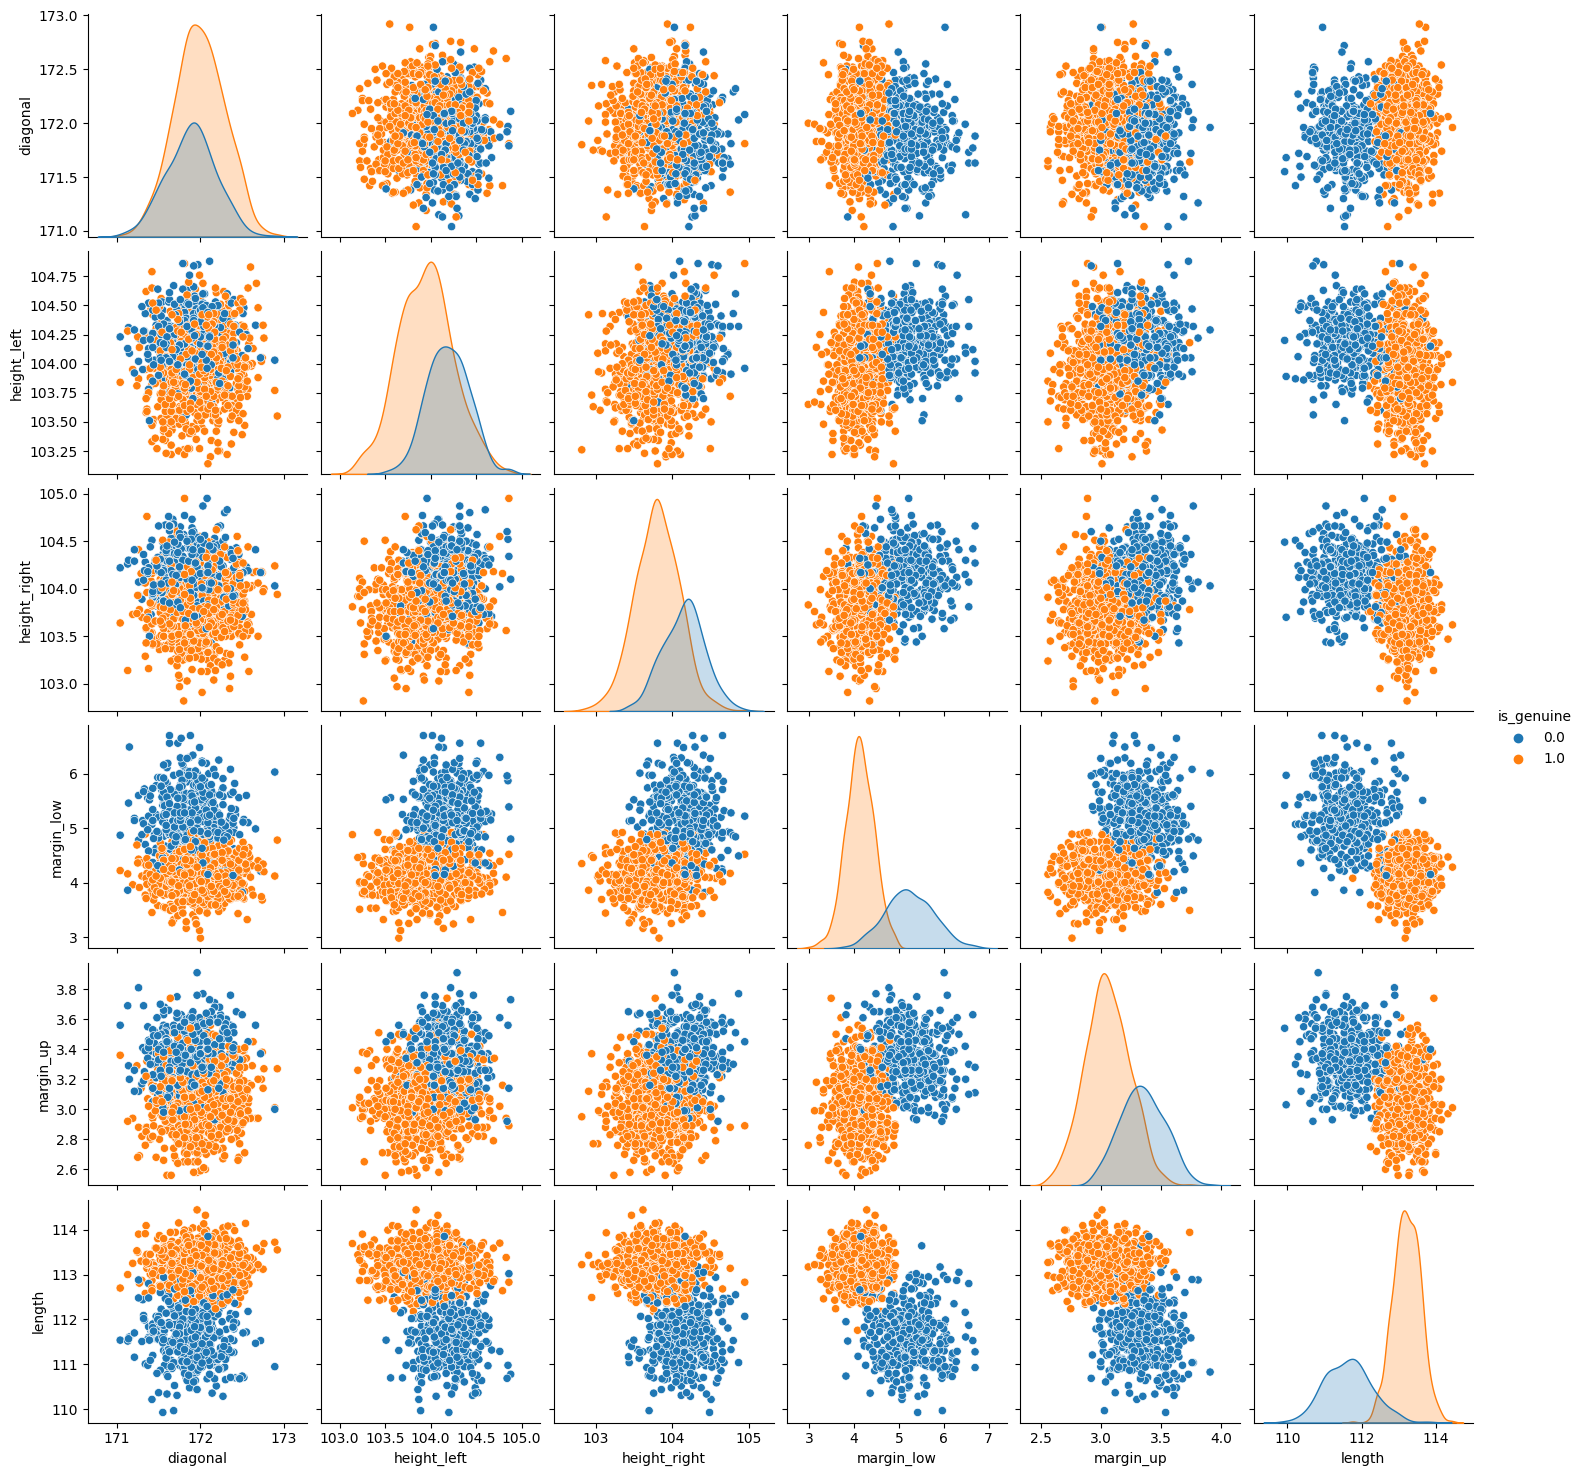

In [110]:
# train_dataset
df_cat = pd.concat([X_train,y_train], axis=1)

sns.pairplot(df_cat, hue='is_genuine')
plt.show()

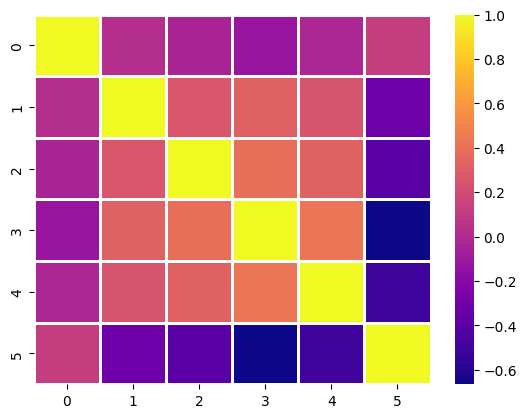

In [111]:
# 자료 확인(corrcoef)
import numpy as np

corr_mat = np.corrcoef(X_train, rowvar=False)

sns.heatmap(corr_mat, linewidth=1, cmap='plasma')

plt.show()

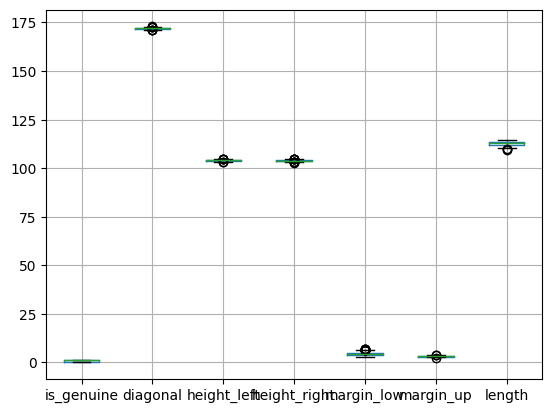

In [112]:
# 자료 확인(Boxplot)
df_imputed2.boxplot()
plt.show()

In [113]:
# standarization으로 normalizing
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train.iloc[:,0:])
X_train.iloc[:,0:]= std.transform(X_train.iloc[:,0:])

X_test.iloc[:,0:] = std.transform(X_test.iloc[:,0:])
X_test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
347,1.659506,-0.818220,-1.147840,-0.916587,0.213368,0.418567
451,0.705531,-0.785100,-1.147840,-0.642937,-1.608992,0.395721
1028,-0.708985,0.076010,0.033808,1.348624,1.471665,-1.534720
677,0.310782,-0.420785,-0.481269,0.041187,-1.912719,0.841208
690,1.231862,-0.652622,-1.147840,-0.779762,0.126589,0.715558


In [114]:
df_cat_std = pd.concat([X_train,y_train], axis=1)

df_cat_std2 = pd.concat([X_test,y_test], axis=1)

In [115]:
# kNN에서 Grid Search(10 fold cross validation)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

grid_params = {
    'n_neighbors' : list(range(1,21)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

gs = GridSearchCV(knn, grid_params, cv=10)
gs.fit(X_train, y_train)

print("Best Parameters : ", gs.best_params_)
print("Best Score : ", gs.best_score_)
print("Best Test Score : ", gs.score(X_test, y_test))

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}
Best Score :  0.9924999999999999
Best Test Score :  0.9933333333333333


In [116]:
knn_best = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 14, weights = 'uniform')
knn_best.fit(X_train, y_train)

print('*** Test Accuracy *** \n   {}'.format(knn_best.score(X_test, y_test)))

*** Test Accuracy *** 
   0.9933333333333333
